In [1]:
import sys, os, glob, warnings, logging
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sw_plotting import change_bar_width, plotCountBar
from sw_utilities import tukeyTest, getCountDFbyPrefix, get_annotated_countDF

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.ERROR)

# ignore warnings
warnings.filterwarnings('ignore')

# plotting configuration
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'

# Make a folder if it is not already there to store exported figures
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [3]:
# Read in the count data by Kaz

datasetFolder = '../data/220509-30-for-bud-count-Kaz/sg-Itga9/'

files = glob.glob(os.path.join(datasetFolder, '*fileNameRecord.txt'))

datasetPrefixes = []
for f in files:
    datasetPrefixes.append('-'.join(os.path.basename(f).split('-')[:3]))

sgRNAs = ["sg-Control"]*5 + ["sg1-Itga9"]*5 + ["sg2-Itga9"]*5 + ["sg3-Itga9"]*5
dfs = []
for datasetPrefix in datasetPrefixes:
    dfs.append( get_annotated_countDF(datasetPrefix, datasetFolder, sgRNAs) )

df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)
df_Kaz = df

In [4]:
df_Kaz.head()

,file_name,scrambled_file_name,counts,sample_id,sgRNA,time_d,groups
0,Plate07152021_WellD02_ChannelMono_Seq0000.nd2,df9053302a6fc5ac6993d26f84e35e31.nd2,40,plateB_4_01,sg-Control,4,sg-Control_4
1,Plate07152021_WellD03_ChannelMono_Seq0001.nd2,b82eb17c7b93202d28e7cf9ebf1d7fbd.nd2,54,plateB_4_02,sg-Control,4,sg-Control_4
2,Plate07152021_WellD04_ChannelMono_Seq0002.nd2,7a825ba231a9ce2ee4b427c74905aac6.nd2,68,plateB_4_03,sg-Control,4,sg-Control_4
3,Plate07152021_WellD05_ChannelMono_Seq0003.nd2,f54179ba949d5b1d8089d6ee564d1beb.nd2,31,plateB_4_04,sg-Control,4,sg-Control_4
4,Plate07152021_WellD06_ChannelMono_Seq0004.nd2,208da9f7e03ed8da93dcbcd298b508e0.nd2,38,plateB_4_05,sg-Control,4,sg-Control_4


In [6]:
# Read in the count data by Rei

datasetFolder = '../data/220509-30-for-bud-count-Rei/sg-Itga9/'

files = glob.glob(os.path.join(datasetFolder, '*fileNameRecord.txt'))

datasetPrefixes = []
for f in files:
    datasetPrefixes.append('-'.join(os.path.basename(f).split('-')[:3]))

sgRNAs = ["sg-Control"]*5 + ["sg1-Itga9"]*5 + ["sg2-Itga9"]*5 + ["sg3-Itga9"]*5
dfs = []
for datasetPrefix in datasetPrefixes:
    dfs.append( get_annotated_countDF(datasetPrefix, datasetFolder, sgRNAs) )

df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)
df_Rei = df

In [7]:
# Merge the two data set and compare the countings of Rei and Kaz
df_Kaz.rename(columns={'counts': 'counts_Kaz'}, inplace=True)
df_Rei.rename(columns={'counts': 'counts_Rei'}, inplace=True)
df = df_Kaz.merge(df_Rei, on=['file_name',
                              'scrambled_file_name',
                              'sample_id',
                              'sgRNA',
                              'time_d',
                              'groups'])
df.head()

,file_name,scrambled_file_name,counts_Kaz,sample_id,sgRNA,time_d,groups,counts_Rei
0,Plate07152021_WellD02_ChannelMono_Seq0000.nd2,df9053302a6fc5ac6993d26f84e35e31.nd2,40,plateB_4_01,sg-Control,4,sg-Control_4,18
1,Plate07152021_WellD03_ChannelMono_Seq0001.nd2,b82eb17c7b93202d28e7cf9ebf1d7fbd.nd2,54,plateB_4_02,sg-Control,4,sg-Control_4,28
2,Plate07152021_WellD04_ChannelMono_Seq0002.nd2,7a825ba231a9ce2ee4b427c74905aac6.nd2,68,plateB_4_03,sg-Control,4,sg-Control_4,39
3,Plate07152021_WellD05_ChannelMono_Seq0003.nd2,f54179ba949d5b1d8089d6ee564d1beb.nd2,31,plateB_4_04,sg-Control,4,sg-Control_4,17
4,Plate07152021_WellD06_ChannelMono_Seq0004.nd2,208da9f7e03ed8da93dcbcd298b508e0.nd2,38,plateB_4_05,sg-Control,4,sg-Control_4,30


In [15]:
# exclude the samples where the sample is outside
# the field of view or severely off-focus
samples_to_exclue = ['plateB_4_14', # outside imaging field
                     'plateC_4_08', # dead
                    ]
df = df[~df.sample_id.isin(samples_to_exclue)]

In [16]:
# calculate average counting data
df['counts'] = (df['counts_Rei'] + df['counts_Kaz']) / 2

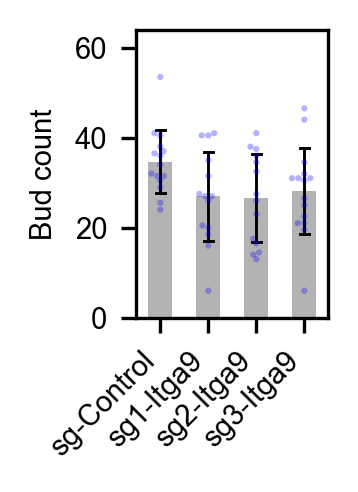

In [27]:
# Make plot for figure

fig_width, fig_height = 0.8, 1.2 # inches

line_width = .8
output_prefix = '220516-plateBCE-E13-d4-sg-Itga9'
outputFigPath = '../jupyter_figures/' + output_prefix + '.svg'
# outputFigPath = '../jupyter_figures/' + output_prefix + '.tif'

fig = plt.figure(figsize=(fig_width,fig_height), dpi=300)
# ax = fig.add_axes([0.28, 0.35, 0.67, 0.6])
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

sns.swarmplot(data = df,
              x = 'sgRNA', y = 'counts',
              color = 'blue',
              alpha = 0.3,
              size = 1.5
             )
sns.barplot(data = df,
            x = 'sgRNA', y = 'counts',
            ci = 'sd',
            color=".7", # This a nicer looking lighter gray to my own taste
            errwidth=.7, errcolor="k", capsize=.2)

plt.ylim(0, 64)
change_bar_width(ax, .5)

# rotate x tick labels if necessary
x_labels = ax.get_xticklabels()
ax.set_xticklabels(labels=x_labels, rotation=45, ha="right")

plt.xlabel("")
plt.ylabel("Bud count")

# ax.get_legend().remove()

for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

plt.savefig(outputFigPath)

In [18]:
tukeyTest(df.counts, df.sgRNA)

Summary of test:
     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
  group1     group2  meandiff p-adj   lower    upper  reject
------------------------------------------------------------
sg-Control sg1-Itga9  -7.7714  0.132 -17.0718   1.529  False
sg-Control sg2-Itga9  -8.1643 0.1046 -17.4647  1.1361  False
sg-Control sg3-Itga9  -6.5667 0.2381 -15.7053   2.572  False
 sg1-Itga9 sg2-Itga9  -0.3929    0.9  -9.8522  9.0665  False
 sg1-Itga9 sg3-Itga9   1.2048    0.9  -8.0956 10.5051  False
 sg2-Itga9 sg3-Itga9   1.5976    0.9  -7.7028  10.898  False
------------------------------------------------------------
p values of all pair-wise tests:
 [0.13198167 0.10457461 0.23813352 0.9        0.9        0.9       ]


In [19]:
for i in df.sgRNA.unique():
    print(i, 'n =', len(df[df.sgRNA==i]))

sg-Control n = 15
sg1-Itga9 n = 14
sg2-Itga9 n = 14
sg3-Itga9 n = 15
